<a href="https://colab.research.google.com/github/jieun0441/XMC/blob/main/Figure_5_Box_Plot_Analysis_(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import os

# 1. 구글 드라이브 마운트 (실행 시 나오는 팝업에서 승인 필요)
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# 경로 설정 (사용자 환경에 맞게 수정)
base_path = '/content/drive/MyDrive/FMC_Data/M_B_dong_data_by_purpose_domestic_residents/'
file_work = 'df_work_intraSeoul.csv'
file_nonwork = 'df_nonwork_intraSeoul.csv'
# ==========================================

In [3]:
path_work = os.path.join(base_path, file_work)
path_nonwork = os.path.join(base_path, file_nonwork)

print(">> 컬럼명만 살짝 확인합니다...")

# 1. Work 파일의 상위 5줄만 읽기
df_work_sample = pd.read_csv(path_work, nrows=5)
print(f"\n[Work File Columns]:\n{df_work_sample.columns.tolist()}")

# 2. Non-Work 파일의 상위 5줄만 읽기
df_nonwork_sample = pd.read_csv(path_nonwork, nrows=5)
print(f"\n[Non-Work File Columns]:\n{df_nonwork_sample.columns.tolist()}")

>> 컬럼명만 살짝 확인합니다...

[Work File Columns]:
['O_ADMDONG_CD', 'D_ADMDONG_CD', 'ST_TIME_CD', 'FNS_TIME_CD', 'MOVE_PURPOSE', 'MOVE_DIST', 'MOVE_TIME', 'CNT', 'ETL_YMD', 'O_Seoul', 'D_Seoul', 'O_SMA', 'D_SMA']

[Non-Work File Columns]:
['O_ADMDONG_CD', 'D_ADMDONG_CD', 'ST_TIME_CD', 'FNS_TIME_CD', 'MOVE_PURPOSE', 'MOVE_DIST', 'MOVE_TIME', 'CNT', 'ETL_YMD', 'O_Seoul', 'D_Seoul', 'O_SMA', 'D_SMA']


# Trip 단위 Box plot

# Destination 기준 box plot 그리기

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import os

# ==========================================
# 1. 설정 및 데이터 로드
# ==========================================
base_path = '/content/drive/MyDrive/FMC_Data/M_B_dong_data_by_purpose_domestic_residents/'
file_cluster = 'Four_category_Seoul_dongs_quadrants_Q1Q4.xlsx'
file_nonwork = 'df_nonwork_intraSeoul.csv'

use_cols = ['D_ADMDONG_CD', 'MOVE_DIST', 'MOVE_TIME', 'CNT']

# 논문용 라벨 및 색상
cluster_info = {
    'All': {'label': 'All Neighborhoods',            'color': '#E0E0E0'},
    'Q1':  {'label': 'Residential Nodes (Q1)',       'color': '#FFEB3B'},
    'Q2':  {'label': 'Leisure & Cultural Hotspots (Q2)', 'color': '#FF69B4'},
    'Q3':  {'label': 'Working Hubs (Q3)',            'color': '#FF0000'},
    'Q4':  {'label': 'Mixed-use Zones (Q4)',         'color': '#FF9800'}
}
plot_order = ['All', 'Q1', 'Q2', 'Q3', 'Q4']

print(">> 1. Cluster 정보를 로드합니다...")
df_cluster = pd.read_excel(os.path.join(base_path, file_cluster), usecols=['dong_cd', 'quadrant'])
df_cluster['dong_cd'] = df_cluster['dong_cd'].astype(str)
dong_to_cluster = df_cluster.set_index('dong_cd')['quadrant'].to_dict()


# ==========================================
# 2. 히스토그램 집계 함수
# ==========================================
def get_dist_time_stats_simultaneous(file_name, target_groups=plot_order):
    print(f"\n>> Analyzing Inbound Trips (Distance & Duration)...")
    path = os.path.join(base_path, file_name)

    dist_bins = np.linspace(0, 100000, 2001)
    time_bins = np.linspace(0, 240, 241)

    hist_dist = {g: np.zeros(len(dist_bins)-1) for g in target_groups}
    hist_time = {g: np.zeros(len(time_bins)-1) for g in target_groups}

    chunk_size = 500000
    for i, chunk in enumerate(pd.read_csv(path, usecols=use_cols, chunksize=chunk_size)):
        if i % 10 == 0: print(f"   ... processing chunk {i+1}")

        chunk['D_ADMDONG_CD'] = chunk['D_ADMDONG_CD'].astype(str)
        chunk['dest_cluster'] = chunk['D_ADMDONG_CD'].map(dong_to_cluster)

        for g in target_groups:
            if g == 'All': subset = chunk
            else: subset = chunk[chunk['dest_cluster'] == g]

            if not subset.empty:
                d_counts, _ = np.histogram(subset['MOVE_DIST'], bins=dist_bins, weights=subset['CNT'])
                hist_dist[g] += d_counts
                t_counts, _ = np.histogram(subset['MOVE_TIME'], bins=time_bins, weights=subset['CNT'])
                hist_time[g] += t_counts

    return hist_dist, hist_time, dist_bins, time_bins


# ==========================================
# 3. 통계(Quantile) 변환 함수
# ==========================================
def calc_quantiles(hist_data, bins, scale_factor=1):
    stats_list = []
    centers = (bins[:-1] + bins[1:]) / 2

    for g in plot_order:
        counts = hist_data[g]
        cumsum = np.cumsum(counts)
        total = cumsum[-1]

        if total > 0:
            norm_cumsum = cumsum / total
            q_vals = np.interp([0.05, 0.25, 0.50, 0.75, 0.95], norm_cumsum, centers)
            avg = np.average(centers, weights=counts)
        else:
            q_vals = [0]*5; avg = 0

        stats_list.append({
            'label': cluster_info[g]['label'],
            'whislo': q_vals[0] / scale_factor, # 5% (Min 역할)
            'q1': q_vals[1] / scale_factor,     # 25%
            'med': q_vals[2] / scale_factor,    # 50% (Median)
            'q3': q_vals[3] / scale_factor,     # 75%
            'whishi': q_vals[4] / scale_factor, # 95% (Max 역할)
            'mean': avg / scale_factor,         # Mean
            'color': cluster_info[g]['color']
        })
    return stats_list



>> 1. Cluster 정보를 로드합니다...



>> Analyzing Inbound Trips (Distance & Duration)...
   ... processing chunk 1
   ... processing chunk 11
   ... processing chunk 21
   ... processing chunk 31
   ... processing chunk 41
   ... processing chunk 51
   ... processing chunk 61
   ... processing chunk 71
   ... processing chunk 81
   ... processing chunk 91
   ... processing chunk 101
   ... processing chunk 111
   ... processing chunk 121
   ... processing chunk 131
   ... processing chunk 141
   ... processing chunk 151
   ... processing chunk 161
   ... processing chunk 171
   ... processing chunk 181
   ... processing chunk 191
   ... processing chunk 201
   ... processing chunk 211
   ... processing chunk 221
   ... processing chunk 231
   ... processing chunk 241
   ... processing chunk 251
   ... processing chunk 261
   ... processing chunk 271
   ... processing chunk 281
   ... processing chunk 291
   ... processing chunk 301
   ... processing chunk 311
   ... processing chunk 321
   ... processing chunk 331
   ...

/tmp/ipython-input-1749324540.py:113: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
/tmp/ipython-input-1749324540.py:113: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,



>> Saving Figures...
   - Figure5_Inbound_Analysis.jpg saved (300dpi)
   - Figure5_Inbound_Analysis.pdf saved


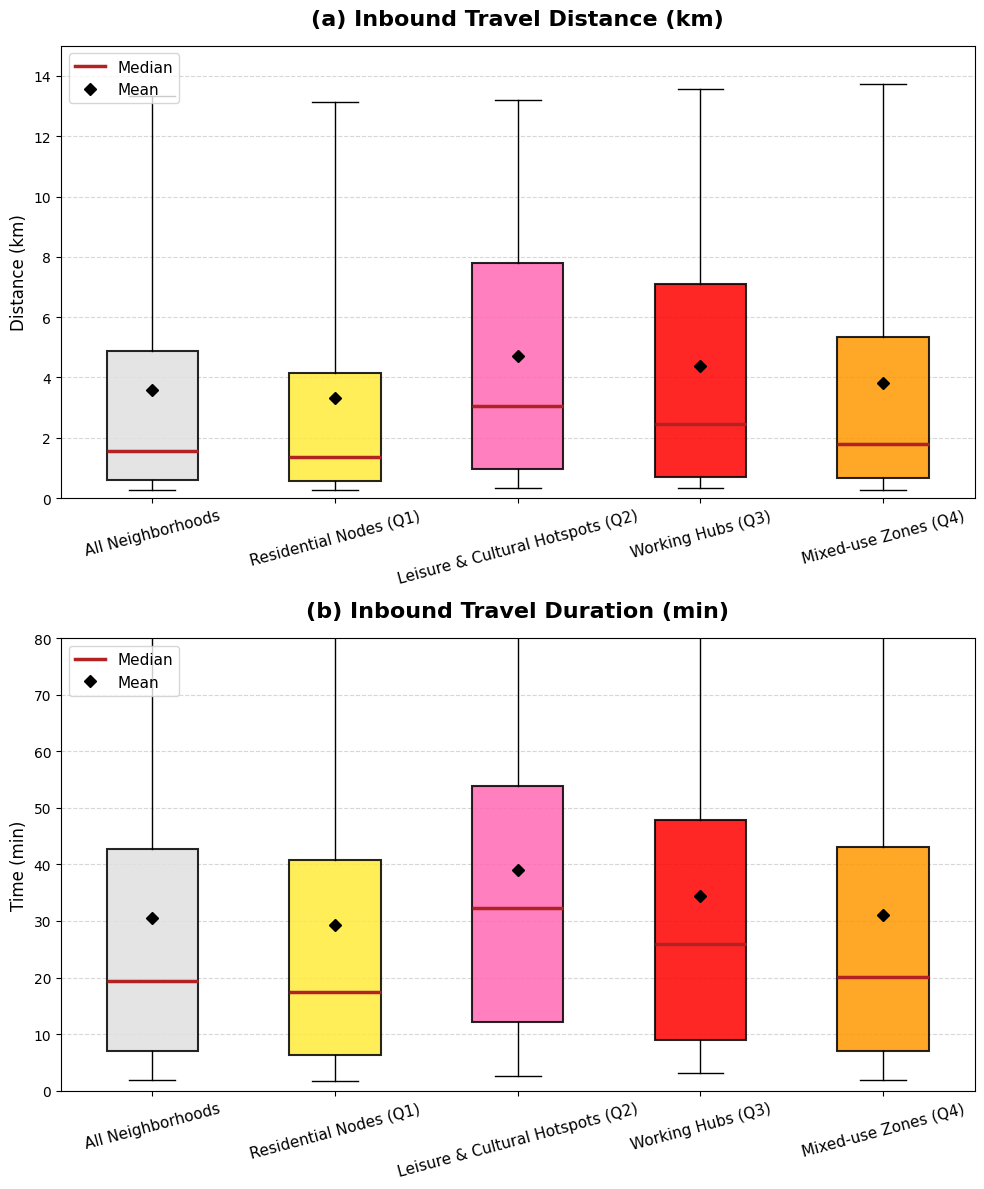


 >>> Inbound Distance (km) Detailed Statistics <<<
Cluster Name                        |     Mean |  Min(5%) |  Q1(25%) |   Median |  Q3(75%) | Max(95%)
-----------------------------------------------------------------------------------------------
All Neighborhoods                   |     3.59 |     0.27 |     0.61 |     1.55 |     4.89 |    13.35
Residential Nodes (Q1)              |     3.32 |     0.26 |     0.56 |     1.35 |     4.14 |    13.13
Leisure & Cultural Hotspots (Q2)    |     4.73 |     0.32 |     0.96 |     3.07 |     7.81 |    13.19
Working Hubs (Q3)                   |     4.37 |     0.33 |     0.71 |     2.45 |     7.10 |    13.56
Mixed-use Zones (Q4)                |     3.80 |     0.27 |     0.67 |     1.79 |     5.33 |    13.73

 >>> Inbound Duration (min) Detailed Statistics <<<
Cluster Name                        |     Mean |  Min(5%) |  Q1(25%) |   Median |  Q3(75%) | Max(95%)
-------------------------------------------------------------------------------------

In [ ]:
# ==========================================
# 4. 실행 및 시각화
# ==========================================
h_d, h_t, bins_d, bins_t = get_dist_time_stats_simultaneous(file_nonwork)
stats_dist = calc_quantiles(h_d, bins_d, scale_factor=1000)
stats_time = calc_quantiles(h_t, bins_t, scale_factor=1)

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# 스타일 정의
boxprops = dict(linestyle='-', linewidth=1.5, color='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='black', markersize=6)

def plot_bxp(ax, stats, title, ylabel, ylim=None):
    bxp_stats = [{k: v for k, v in item.items() if k != 'color'} for item in stats]
    bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
                boxprops=boxprops, medianprops=medianprops)

    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(stats[i]['color'])
        patch.set_alpha(0.85)

    means = [item['mean'] for item in stats]
    ax.plot(range(1, 6), means, 'D', color='black', markersize=6, zorder=10)

    ax.set_title(title, fontsize=16, fontweight='bold', pad=15)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', labelsize=11, rotation=15) # 라벨 회전
    if ylim: ax.set_ylim(ylim)

plot_bxp(axes[0], stats_dist, '(a) Inbound Travel Distance (km)', 'Distance (km)', ylim=(0, 15))
plot_bxp(axes[1], stats_time, '(b) Inbound Travel Duration (min)', 'Time (min)', ylim=(0, 80))

legend_elements = [
    mlines.Line2D([], [], color='firebrick', linewidth=2.5, label='Median'),
    mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=6, label='Mean')
]
axes[0].legend(handles=legend_elements, loc='upper left', fontsize=11, frameon=True)
axes[1].legend(handles=legend_elements, loc='upper left', fontsize=11, frameon=True)

plt.tight_layout()

# ==========================================
# [추가됨] 5. 파일 저장 (JPG & PDF)
# ==========================================
# bbox_inches='tight' 옵션은 여백을 자동으로 조절하여 글자가 잘리는 것을 방지합니다.
print("\n>> Saving Figures...")
plt.savefig('Figure5_Inbound_Analysis.jpg', dpi=300, bbox_inches='tight')
plt.savefig('Figure5_Inbound_Analysis.pdf', bbox_inches='tight')
print("   - Figure5_Inbound_Analysis.jpg saved (300dpi)")
print("   - Figure5_Inbound_Analysis.pdf saved")

plt.show()


# ==========================================
# 6. 상세 결과값 전체 출력
# ==========================================
def print_full_stats_table(stats_list, unit_name):
    print(f"\n" + "="*95)
    print(f" >>> {unit_name} Detailed Statistics <<<")
    print("="*95)
    header = f"{'Cluster Name':<35} | {'Mean':>8} | {'Min(5%)':>8} | {'Q1(25%)':>8} | {'Median':>8} | {'Q3(75%)':>8} | {'Max(95%)':>8}"
    print(header)
    print("-" * 95)

    for s in stats_list:
        row = f"{s['label']:<35} | {s['mean']:8.2f} | {s['whislo']:8.2f} | {s['q1']:8.2f} | {s['med']:8.2f} | {s['q3']:8.2f} | {s['whishi']:8.2f}"
        print(row)
    print("="*95)

print_full_stats_table(stats_dist, "Inbound Distance (km)")
print_full_stats_table(stats_time, "Inbound Duration (min)")


>> Analyzing Inbound Trips (Distance & Duration)...
   ... processing chunk 1
   ... processing chunk 11
   ... processing chunk 21
   ... processing chunk 31
   ... processing chunk 41
   ... processing chunk 51
   ... processing chunk 61
   ... processing chunk 71
   ... processing chunk 81
   ... processing chunk 91
   ... processing chunk 101
   ... processing chunk 111
   ... processing chunk 121
   ... processing chunk 131
   ... processing chunk 141
   ... processing chunk 151
   ... processing chunk 161
   ... processing chunk 171
   ... processing chunk 181
   ... processing chunk 191
   ... processing chunk 201
   ... processing chunk 211
   ... processing chunk 221
   ... processing chunk 231
   ... processing chunk 241
   ... processing chunk 251
   ... processing chunk 261
   ... processing chunk 271
   ... processing chunk 281
   ... processing chunk 291
   ... processing chunk 301
   ... processing chunk 311
   ... processing chunk 321
   ... processing chunk 331
   ...

/tmp/ipython-input-1540241460.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
/tmp/ipython-input-1540241460.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,



>> Saving Figures...
   - Figure5_Inbound_Analysis.jpg saved (300dpi)
   - Figure5_Inbound_Analysis.pdf saved


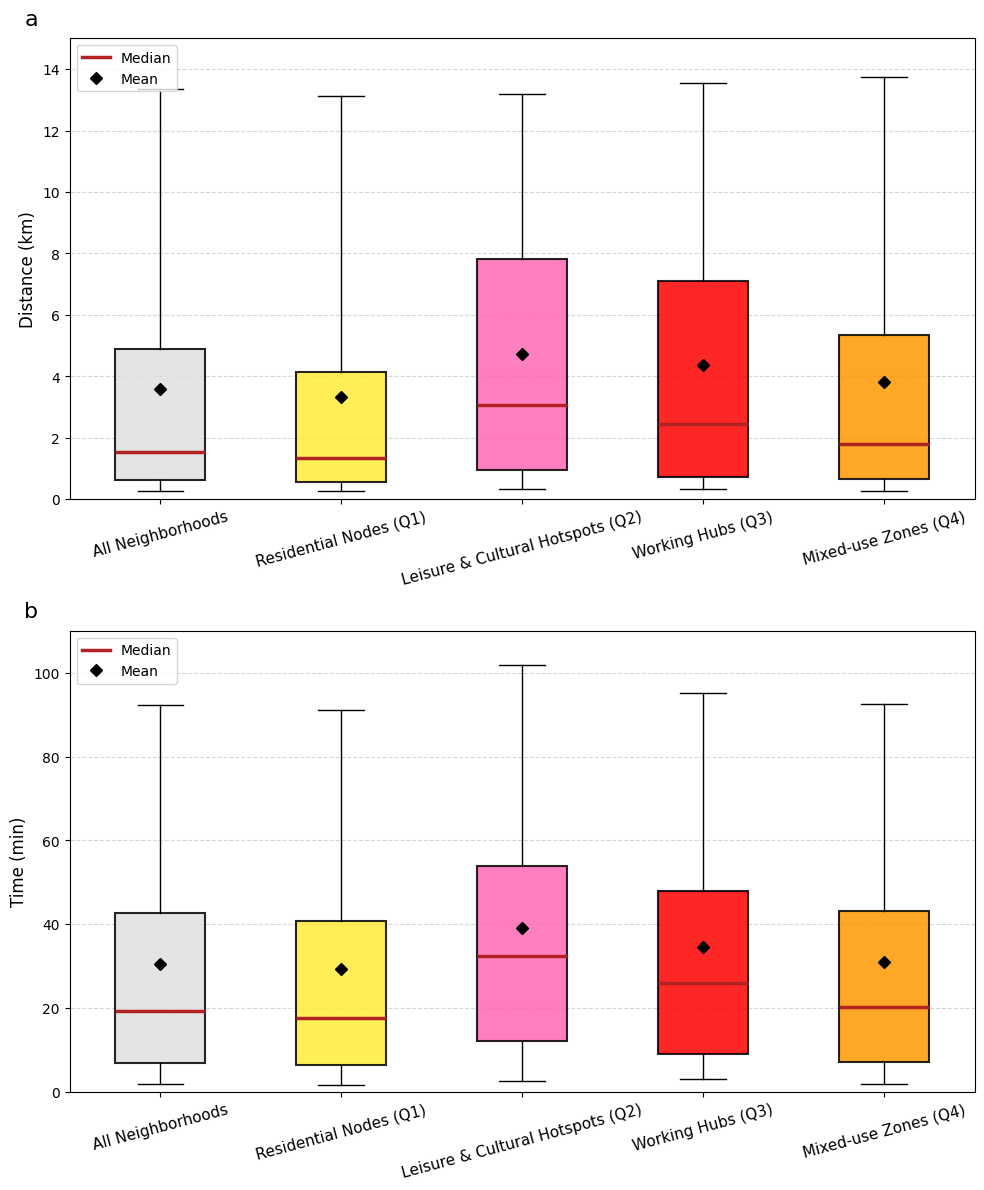


 >>> Inbound Distance (km) Detailed Statistics <<<
Cluster Name                        |     Mean |  Min(5%) |  Q1(25%) |   Median |  Q3(75%) | Max(95%)
-----------------------------------------------------------------------------------------------
All Neighborhoods                   |     3.59 |     0.27 |     0.61 |     1.55 |     4.89 |    13.35
Residential Nodes (Q1)              |     3.32 |     0.26 |     0.56 |     1.35 |     4.14 |    13.13
Leisure & Cultural Hotspots (Q2)    |     4.73 |     0.32 |     0.96 |     3.07 |     7.81 |    13.19
Working Hubs (Q3)                   |     4.37 |     0.33 |     0.71 |     2.45 |     7.10 |    13.56
Mixed-use Zones (Q4)                |     3.80 |     0.27 |     0.67 |     1.79 |     5.33 |    13.73

 >>> Inbound Duration (min) Detailed Statistics <<<
Cluster Name                        |     Mean |  Min(5%) |  Q1(25%) |   Median |  Q3(75%) | Max(95%)
-------------------------------------------------------------------------------------

In [ ]:
#@title Fig5 패널 제목 괄호 없이 왼쪽 상단 위치하게 수정
# ==========================================
# 4. 실행 및 시각화 (수정된 부분)
# ==========================================
h_d, h_t, bins_d, bins_t = get_dist_time_stats_simultaneous(file_nonwork)
stats_dist = calc_quantiles(h_d, bins_d, scale_factor=1000)
stats_time = calc_quantiles(h_t, bins_t, scale_factor=1)

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# 스타일 정의
boxprops = dict(linestyle='-', linewidth=1.5, color='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='black', markersize=6)

# [수정됨] title 인자를 panel_label로 변경하고 로직 수정
def plot_bxp(ax, stats, panel_label, ylabel, ylim=None):
    bxp_stats = [{k: v for k, v in item.items() if k != 'color'} for item in stats]
    bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
                boxprops=boxprops, medianprops=medianprops)

    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(stats[i]['color'])
        patch.set_alpha(0.85)

    means = [item['mean'] for item in stats]
    ax.plot(range(1, 6), means, 'D', color='black', markersize=6, zorder=10)

    # [수정됨] ax.set_title 제거하고 ax.text 사용
    # 왼쪽 상단(-0.05, 1.02 위치)에 라벨 표시
    # fontweight='normal' (굵지 않게), 괄호 없음
    ax.text(-0.05, 1.02, panel_label, transform=ax.transAxes,
            fontsize=16,       # <--- 여기를 16로 조절
            fontweight='normal', va='bottom', ha='left')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', labelsize=11, rotation=15)
    if ylim: ax.set_ylim(ylim)

# [수정됨] 함수 호출 시 제목 대신 'a', 'b' 전달
plot_bxp(axes[0], stats_dist, 'a', 'Distance (km)', ylim=(0, 15))
plot_bxp(axes[1], stats_time, 'b', 'Time (min)', ylim=(0, 110))

legend_elements = [
    mlines.Line2D([], [], color='firebrick', linewidth=2.5, label='Median'),
    mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=6, label='Mean')
]
axes[0].legend(handles=legend_elements, loc='upper left', fontsize=10, frameon=True)
axes[1].legend(handles=legend_elements, loc='upper left', fontsize=10, frameon=True)

plt.tight_layout()

# ==========================================
# 5. 파일 저장 (JPG & PDF)
# ==========================================
print("\n>> Saving Figures...")
plt.savefig('Figure5_Inbound_Analysis_16pt.jpg', dpi=300, bbox_inches='tight')
plt.savefig('Figure5_Inbound_Analysis_16pt.pdf', bbox_inches='tight')
print("   - Figure5_Inbound_Analysis.jpg saved (300dpi)")
print("   - Figure5_Inbound_Analysis.pdf saved")

plt.show()


# ==========================================
# 6. 상세 결과값 전체 출력
# ==========================================
def print_full_stats_table(stats_list, unit_name):
    print(f"\n" + "="*95)
    print(f" >>> {unit_name} Detailed Statistics <<<")
    print("="*95)
    header = f"{'Cluster Name':<35} | {'Mean':>8} | {'Min(5%)':>8} | {'Q1(25%)':>8} | {'Median':>8} | {'Q3(75%)':>8} | {'Max(95%)':>8}"
    print(header)
    print("-" * 95)

    for s in stats_list:
        row = f"{s['label']:<35} | {s['mean']:8.2f} | {s['whislo']:8.2f} | {s['q1']:8.2f} | {s['med']:8.2f} | {s['q3']:8.2f} | {s['whishi']:8.2f}"
        print(row)
    print("="*95)

print_full_stats_table(stats_dist, "Inbound Distance (km)")
print_full_stats_table(stats_time, "Inbound Duration (min)")


>> Analyzing Inbound Trips (Distance & Duration)...
   ... processing chunk 1
   ... processing chunk 11
   ... processing chunk 21
   ... processing chunk 31
   ... processing chunk 41
   ... processing chunk 51
   ... processing chunk 61
   ... processing chunk 71
   ... processing chunk 81
   ... processing chunk 91
   ... processing chunk 101
   ... processing chunk 111
   ... processing chunk 121
   ... processing chunk 131
   ... processing chunk 141
   ... processing chunk 151
   ... processing chunk 161
   ... processing chunk 171
   ... processing chunk 181
   ... processing chunk 191
   ... processing chunk 201
   ... processing chunk 211
   ... processing chunk 221
   ... processing chunk 231
   ... processing chunk 241
   ... processing chunk 251
   ... processing chunk 261
   ... processing chunk 271
   ... processing chunk 281
   ... processing chunk 291
   ... processing chunk 301
   ... processing chunk 311
   ... processing chunk 321
   ... processing chunk 331
   ...

/tmp/ipython-input-215/3684217392.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
/tmp/ipython-input-215/3684217392.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
/tmp/ipython-input-215/3684217392.py:98: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = mpatches.Patch(color=s['color'], alpha=0.85, edgecolor='black', linewidth=0.5, label=new_label)



>> Saving Figure 5 (High Resolution, 88mm)...


   - Figure5_Inbound_Analysis_Fixed.jpg saved
   - Figure5_Inbound_Analysis_Fixed.pdf saved


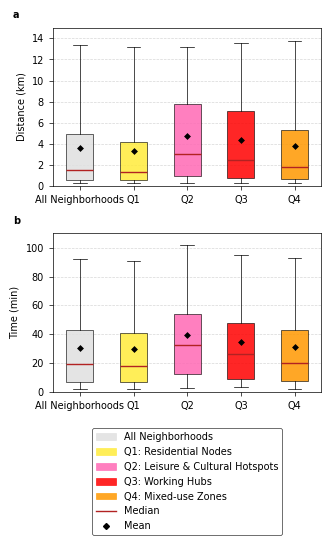


 >>> Inbound Distance (km) Detailed Statistics <<<
Cluster Name                        |     Mean |  Min(5%) |  Q1(25%) |   Median |  Q3(75%) | Max(95%)
-----------------------------------------------------------------------------------------------
All Neighborhoods                   |     3.59 |     0.27 |     0.61 |     1.55 |     4.89 |    13.35
Residential Nodes (Q1)              |     3.32 |     0.26 |     0.56 |     1.35 |     4.14 |    13.13
Leisure & Cultural Hotspots (Q2)    |     4.73 |     0.32 |     0.96 |     3.07 |     7.81 |    13.19
Working Hubs (Q3)                   |     4.37 |     0.33 |     0.71 |     2.45 |     7.10 |    13.56
Mixed-use Zones (Q4)                |     3.80 |     0.27 |     0.67 |     1.79 |     5.33 |    13.73

 >>> Inbound Duration (min) Detailed Statistics <<<
Cluster Name                        |     Mean |  Min(5%) |  Q1(25%) |   Median |  Q3(75%) | Max(95%)
-------------------------------------------------------------------------------------

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# [선택] 폰트 강제 설정 (앞선 셀에서 이미 적용했다면 생략 가능하지만 안전하게 추가)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# ==========================================
# 4. 실행 및 시각화 (88mm 저널 1단 포맷 맞춤형)
# ==========================================

h_d, h_t, bins_d, bins_t = get_dist_time_stats_simultaneous(file_nonwork)
stats_dist = calc_quantiles(h_d, bins_d, scale_factor=1000)
stats_time = calc_quantiles(h_t, bins_t, scale_factor=1)

# X축 라벨을 'Q1', 'Q2' 형태로 단순화하는 작업
for s in stats_dist + stats_time:
    full_label = s['label']
    if '(' in full_label:
        # "Residential Nodes (Q1)" -> "Q1" 추출
        s['short_label'] = full_label.split('(')[-1].replace(')', '')
    else:
        s['short_label'] = full_label

# 88mm를 inch로 변환
mm_to_inch = 1 / 25.4
fig_width = 88 * mm_to_inch
fig_height = 120 * mm_to_inch # 위아래 패널 2개 + 하단 범례 공간을 고려해 세로 길이 설정

fig, axes = plt.subplots(2, 1, figsize=(fig_width, fig_height))

# 선 두께 0.5pt로 얇게, 마커 크기 축소
boxprops = dict(linestyle='-', linewidth=0.5, color='black')
medianprops = dict(linestyle='-', linewidth=1.0, color='firebrick') # 중앙값은 약간 두껍게(1.0)
meanprops = dict(marker='D', markeredgecolor='black', markeredgewidth=0.5, markerfacecolor='black', markersize=3)
whiskerprops = dict(linewidth=0.5, color='black')
capprops = dict(linewidth=0.5, color='black')

def plot_bxp(ax, stats, panel_label, ylabel, ylim=None):
    # bxp에 들어갈 데이터 정리 (short_label 적용)
    bxp_stats = []
    for item in stats:
        d = {k: v for k, v in item.items() if k not in ('color', 'short_label')}
        d['label'] = item.get('short_label', item['label'])
        bxp_stats.append(d)

    # boxplot 그리기 (플라이어 미포함, 두께 설정 적용)
    bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops)

    # 박스 색상 지정 및 테두리 얇게 설정
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(stats[i]['color'])
        patch.set_linewidth(0.5)
        patch.set_alpha(0.85)

    # 평균값(Mean) 마커 찍기
    means = [item['mean'] for item in stats]
    ax.plot(range(1, len(means)+1), means, 'D', color='black',
            markersize=3, zorder=10, markeredgewidth=0.5)

    # 패널 제목 (a, b) - 저널 규격에 맞춰 왼쪽 위 바깥쪽에 작게(7pt) 표시
    ax.text(-0.15, 1.05, panel_label, transform=ax.transAxes,
            fontsize=7, fontweight='bold', va='bottom', ha='left')

    # 축 설정 (글씨 7pt 제한)
    ax.set_ylabel(ylabel, fontsize=7)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.tick_params(axis='both', labelsize=7, width=0.5, length=3)

    # 축 테두리(Spines) 두께 얇게
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    if ylim: ax.set_ylim(ylim)

# 함수 호출 시 패널 라벨 'a', 'b' 전달
plot_bxp(axes[0], stats_dist, 'a', 'Distance (km)', ylim=(0, 15))
plot_bxp(axes[1], stats_time, 'b', 'Time (min)', ylim=(0, 110))

# ==========================================
# 하단 통합 범례(Legend) 생성
# ==========================================
# 1. 막대 카테고리 (Q1, Q2, ...) 패치 생성
legend_elements = []
for s in stats_dist:
    full_label = s['label']
    if '(' in full_label:
        name_part = full_label.split(' (')[0]
        code_part = full_label.split('(')[-1].replace(')', '')
        new_label = f"{code_part}: {name_part}"
    else:
        new_label = full_label

    patch = mpatches.Patch(color=s['color'], alpha=0.85, edgecolor='black', linewidth=0.5, label=new_label)
    legend_elements.append(patch)

# 2. Mean, Median 라인/마커 추가
legend_elements.append(mlines.Line2D([], [], color='firebrick', linewidth=1.0, label='Median'))
legend_elements.append(mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=3, label='Mean'))

# 아래쪽 축(axes[1])의 하단에 통합 범례 배치
legend = axes[1].legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, -0.2), # 그래프 아래쪽으로 밀어냄
                        ncol=1, fontsize=7, frameon=True)

legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor('black')

# 여백 자동 조정 (범례가 잘리지 않도록 공간 확보)
plt.subplots_adjust(hspace=0.3)

# ==========================================
# 5. 파일 저장 (JPG & PDF)
# ==========================================
print("\n>> Saving Figure 5 (High Resolution, 88mm)...")
# bbox_inches='tight' 옵션으로 하단 범례가 잘리지 않고 온전히 저장됨
plt.savefig('Figure5_Inbound_Analysis_Fixed.jpg', dpi=300, bbox_inches='tight')
plt.savefig('Figure5_Inbound_Analysis_Fixed.pdf', bbox_inches='tight')
print("   - Figure5_Inbound_Analysis_Fixed.jpg saved")
print("   - Figure5_Inbound_Analysis_Fixed.pdf saved")

plt.show()

# ==========================================
# 6. 상세 결과값 전체 출력 (기존과 동일)
# ==========================================
def print_full_stats_table(stats_list, unit_name):
    print(f"\n" + "="*95)
    print(f" >>> {unit_name} Detailed Statistics <<<")
    print("="*95)
    header = f"{'Cluster Name':<35} | {'Mean':>8} | {'Min(5%)':>8} | {'Q1(25%)':>8} | {'Median':>8} | {'Q3(75%)':>8} | {'Max(95%)':>8}"
    print(header)
    print("-" * 95)

    for s in stats_list:
        row = f"{s['label']:<35} | {s['mean']:8.2f} | {s['whislo']:8.2f} | {s['q1']:8.2f} | {s['med']:8.2f} | {s['q3']:8.2f} | {s['whishi']:8.2f}"
        print(row)
    print("="*95)

print_full_stats_table(stats_dist, "Inbound Distance (km)")
print_full_stats_table(stats_time, "Inbound Duration (min)")

/tmp/ipython-input-215/1476383631.py:55: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
/tmp/ipython-input-215/1476383631.py:55: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
/tmp/ipython-input-215/1476383631.py:103: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = mpatches.Patch(color=s['color'], alpha=0.85, edgecolor='black', linewidth=0.5, label=new_label)



>> Saving Figure 5 (High Resolution, 88mm)...


   - Figure5_Inbound_Analysis_Fixed.jpg saved
   - Figure5_Inbound_Analysis_Fixed.pdf saved


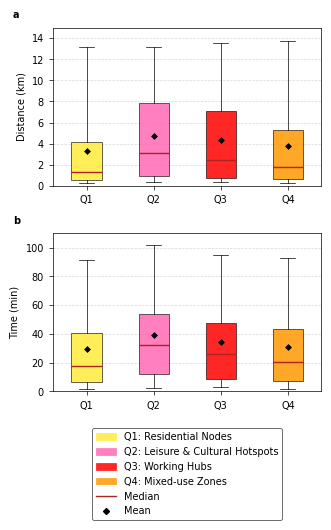


 >>> Inbound Distance (km) Detailed Statistics <<<
Cluster Name                        |     Mean |  Min(5%) |  Q1(25%) |   Median |  Q3(75%) | Max(95%)
-----------------------------------------------------------------------------------------------
Residential Nodes (Q1)              |     3.32 |     0.26 |     0.56 |     1.35 |     4.14 |    13.13
Leisure & Cultural Hotspots (Q2)    |     4.73 |     0.32 |     0.96 |     3.07 |     7.81 |    13.19
Working Hubs (Q3)                   |     4.37 |     0.33 |     0.71 |     2.45 |     7.10 |    13.56
Mixed-use Zones (Q4)                |     3.80 |     0.27 |     0.67 |     1.79 |     5.33 |    13.73

 >>> Inbound Duration (min) Detailed Statistics <<<
Cluster Name                        |     Mean |  Min(5%) |  Q1(25%) |   Median |  Q3(75%) | Max(95%)
-----------------------------------------------------------------------------------------------
Residential Nodes (Q1)              |    29.31 |     1.68 |     6.38 |    17.49 |    40.74 

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# [선택] 폰트 강제 설정
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# ==========================================
# 4. 실행 및 시각화 (88mm 저널 1단 포맷 맞춤형)
# ==========================================
# (가정: h_d, h_t, stats_dist, stats_time은 이미 계산되었다고 전제합니다.)
# h_d, h_t, bins_d, bins_t = get_dist_time_stats_simultaneous(file_nonwork)
# stats_dist = calc_quantiles(h_d, bins_d, scale_factor=1000)
# stats_time = calc_quantiles(h_t, bins_t, scale_factor=1)

# [핵심 추가] 'All Neighborhoods'를 제외하고 Q1~Q4 그룹만 남기기
# 라벨 이름에 'Q'가 포함된 항목만 필터링합니다.
stats_dist = [s for s in stats_dist if 'Q' in s['label']]
stats_time = [s for s in stats_time if 'Q' in s['label']]

# X축 라벨을 'Q1', 'Q2' 형태로 단순화하는 작업
for s in stats_dist + stats_time:
    full_label = s['label']
    if '(' in full_label:
        # "Residential Nodes (Q1)" -> "Q1" 추출
        s['short_label'] = full_label.split('(')[-1].replace(')', '')
    else:
        s['short_label'] = full_label

# 88mm를 inch로 변환
mm_to_inch = 1 / 25.4
fig_width = 88 * mm_to_inch
fig_height = 120 * mm_to_inch # 위아래 패널 2개 + 하단 범례 공간을 고려해 세로 길이 설정

fig, axes = plt.subplots(2, 1, figsize=(fig_width, fig_height))

# 선 두께 0.5pt로 얇게, 마커 크기 축소
boxprops = dict(linestyle='-', linewidth=0.5, color='black')
medianprops = dict(linestyle='-', linewidth=1.0, color='firebrick') # 중앙값은 약간 두껍게(1.0)
meanprops = dict(marker='D', markeredgecolor='black', markeredgewidth=0.5, markerfacecolor='black', markersize=3)
whiskerprops = dict(linewidth=0.5, color='black')
capprops = dict(linewidth=0.5, color='black')

def plot_bxp(ax, stats, panel_label, ylabel, ylim=None):
    # bxp에 들어갈 데이터 정리 (short_label 적용)
    bxp_stats = []
    for item in stats:
        d = {k: v for k, v in item.items() if k not in ('color', 'short_label')}
        d['label'] = item.get('short_label', item['label'])
        bxp_stats.append(d)

    # boxplot 그리기 (플라이어 미포함, 두께 설정 적용)
    bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops)

    # 박스 색상 지정 및 테두리 얇게 설정
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(stats[i]['color'])
        patch.set_linewidth(0.5)
        patch.set_alpha(0.85)

    # 평균값(Mean) 마커 찍기
    means = [item['mean'] for item in stats]
    ax.plot(range(1, len(means)+1), means, 'D', color='black',
            markersize=3, zorder=10, markeredgewidth=0.5)

    # 패널 제목 (a, b) - 저널 규격에 맞춰 왼쪽 위 바깥쪽에 작게(7pt) 표시
    ax.text(-0.15, 1.05, panel_label, transform=ax.transAxes,
            fontsize=7, fontweight='bold', va='bottom', ha='left')

    # 축 설정 (글씨 7pt 제한)
    ax.set_ylabel(ylabel, fontsize=7)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.tick_params(axis='both', labelsize=7, width=0.5, length=3)

    # 축 테두리(Spines) 두께 얇게
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    if ylim: ax.set_ylim(ylim)

# 함수 호출 시 패널 라벨 'a', 'b' 전달
plot_bxp(axes[0], stats_dist, 'a', 'Distance (km)', ylim=(0, 15))
plot_bxp(axes[1], stats_time, 'b', 'Time (min)', ylim=(0, 110))

# ==========================================
# 하단 통합 범례(Legend) 생성
# ==========================================
# 1. 막대 카테고리 (Q1, Q2, ...) 패치 생성
legend_elements = []
for s in stats_dist:
    full_label = s['label']
    if '(' in full_label:
        name_part = full_label.split(' (')[0]
        code_part = full_label.split('(')[-1].replace(')', '')
        new_label = f"{code_part}: {name_part}"
    else:
        new_label = full_label

    patch = mpatches.Patch(color=s['color'], alpha=0.85, edgecolor='black', linewidth=0.5, label=new_label)
    legend_elements.append(patch)

# 2. Mean, Median 라인/마커 추가
legend_elements.append(mlines.Line2D([], [], color='firebrick', linewidth=1.0, label='Median'))
legend_elements.append(mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=3, label='Mean'))

# 아래쪽 축(axes[1])의 하단에 통합 범례 배치
legend = axes[1].legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, -0.2), # 그래프 아래쪽으로 밀어냄
                        ncol=1, fontsize=7, frameon=True)

legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor('black')

# 여백 자동 조정 (범례가 잘리지 않도록 공간 확보)
plt.subplots_adjust(hspace=0.3)

# ==========================================
# 5. 파일 저장 (JPG & PDF)
# ==========================================
print("\n>> Saving Figure 5 (High Resolution, 88mm)...")
plt.savefig('Figure5_Inbound_Analysis_Fixed.jpg', dpi=300, bbox_inches='tight')
plt.savefig('Figure5_Inbound_Analysis_Fixed.pdf', bbox_inches='tight')
print("   - Figure5_Inbound_Analysis_Fixed.jpg saved")
print("   - Figure5_Inbound_Analysis_Fixed.pdf saved")

plt.show()

# ==========================================
# 6. 상세 결과값 전체 출력
# ==========================================
def print_full_stats_table(stats_list, unit_name):
    print(f"\n" + "="*95)
    print(f" >>> {unit_name} Detailed Statistics <<<")
    print("="*95)
    header = f"{'Cluster Name':<35} | {'Mean':>8} | {'Min(5%)':>8} | {'Q1(25%)':>8} | {'Median':>8} | {'Q3(75%)':>8} | {'Max(95%)':>8}"
    print(header)
    print("-" * 95)

    for s in stats_list:
        row = f"{s['label']:<35} | {s['mean']:8.2f} | {s['whislo']:8.2f} | {s['q1']:8.2f} | {s['med']:8.2f} | {s['q3']:8.2f} | {s['whishi']:8.2f}"
        print(row)
    print("="*95)

print_full_stats_table(stats_dist, "Inbound Distance (km)")
print_full_stats_table(stats_time, "Inbound Duration (min)")

>> Downloading and setting Arial font...


/tmp/ipython-input-215/3505738257.py:65: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
/tmp/ipython-input-215/3505738257.py:65: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
/tmp/ipython-input-215/3505738257.py:112: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = mpatches.Patch(color=s['color'], alpha=0.85, edgecolor='black', linewidth=0.5, label=new_label)



>> Saving Figure 5 (High Resolution, 88mm)...
   - Figure5_Inbound_Analysis_Fixed.jpg saved
   - Figure5_Inbound_Analysis_Fixed.pdf saved


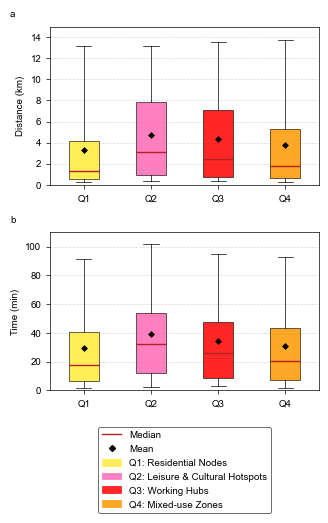

In [9]:
#@title 최종 Figure 5
import urllib.request
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# ==========================================
# 0. Colab 환경에 Arial 폰트 완벽 적용 (Warning 해결)
# ==========================================
print(">> Downloading and setting Arial font...")
font_url = "https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf"
font_path = "Arial.ttf"
if not os.path.exists(font_path):
    urllib.request.urlretrieve(font_url, font_path)

# 폰트 매니저에 강제 추가 후, 폰트의 실제 내부 이름(name)을 가져와서 적용
fm.fontManager.addfont(font_path)
arial_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = arial_prop.get_name() # 정확한 폰트 이름으로 덮어쓰기

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['mathtext.default'] = 'regular' # 수식 폰트 동기화


# ==========================================
# 4. 실행 및 시각화 (88mm 저널 1단 포맷 맞춤형)
# ==========================================
# (가정: h_d, h_t, stats_dist, stats_time은 이미 계산되었다고 전제합니다.)

# 'All Neighborhoods'를 제외하고 Q1~Q4 그룹만 남기기
stats_dist = [s for s in stats_dist if 'Q' in s['label']]
stats_time = [s for s in stats_time if 'Q' in s['label']]

# X축 라벨을 'Q1', 'Q2' 형태로 단순화하는 작업
for s in stats_dist + stats_time:
    full_label = s['label']
    if '(' in full_label:
        s['short_label'] = full_label.split('(')[-1].replace(')', '')
    else:
        s['short_label'] = full_label

# 88mm를 inch로 변환
mm_to_inch = 1 / 25.4
fig_width = 88 * mm_to_inch
fig_height = 120 * mm_to_inch

fig, axes = plt.subplots(2, 1, figsize=(fig_width, fig_height))

# 선 두께 0.5pt로 얇게, 마커 크기 축소
boxprops = dict(linestyle='-', linewidth=0.5, color='black')
medianprops = dict(linestyle='-', linewidth=1.0, color='firebrick')
meanprops = dict(marker='D', markeredgecolor='black', markeredgewidth=0.5, markerfacecolor='black', markersize=3)
whiskerprops = dict(linewidth=0.5, color='black')
capprops = dict(linewidth=0.5, color='black')

def plot_bxp(ax, stats, panel_label, ylabel, ylim=None):
    bxp_stats = []
    for item in stats:
        d = {k: v for k, v in item.items() if k not in ('color', 'short_label')}
        d['label'] = item.get('short_label', item['label'])
        bxp_stats.append(d)

    bp = ax.bxp(bxp_stats, showfliers=False, patch_artist=True,
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops)

    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(stats[i]['color'])
        patch.set_linewidth(0.5)
        patch.set_alpha(0.85)

    means = [item['mean'] for item in stats]
    ax.plot(range(1, len(means)+1), means, 'D', color='black',
            markersize=3, zorder=10, markeredgewidth=0.5)

    ax.text(-0.15, 1.05, panel_label, transform=ax.transAxes,
            fontsize=7, fontweight='bold', va='bottom', ha='left')

    ax.set_ylabel(ylabel, fontsize=7)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.tick_params(axis='both', labelsize=7, width=0.5, length=3)

    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    if ylim: ax.set_ylim(ylim)

plot_bxp(axes[0], stats_dist, 'a', 'Distance (km)', ylim=(0, 15))
plot_bxp(axes[1], stats_time, 'b', 'Time (min)', ylim=(0, 110))

# ==========================================
# 하단 통합 범례(Legend) 생성 (순서 변경 적용)
# ==========================================
legend_elements = []

# [수정] 1. Mean, Median 라인/마커 먼저 추가
legend_elements.append(mlines.Line2D([], [], color='firebrick', linewidth=1.0, label='Median'))
legend_elements.append(mlines.Line2D([], [], color='black', marker='D', linestyle='None', markersize=3, label='Mean'))

# [수정] 2. 막대 카테고리 (Q1, Q2, ...) 패치 나중에 추가
for s in stats_dist:
    full_label = s['label']
    if '(' in full_label:
        name_part = full_label.split(' (')[0]
        code_part = full_label.split('(')[-1].replace(')', '')
        new_label = f"{code_part}: {name_part}"
    else:
        new_label = full_label

    patch = mpatches.Patch(color=s['color'], alpha=0.85, edgecolor='black', linewidth=0.5, label=new_label)
    legend_elements.append(patch)

# 범례 그리기
legend = axes[1].legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, -0.2),
                        ncol=1, fontsize=7, frameon=True)

legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor('black')

plt.subplots_adjust(hspace=0.3)

# ==========================================
# 5. 파일 저장 (JPG & PDF)
# ==========================================
print("\n>> Saving Figure 5 (High Resolution, 88mm)...")
plt.savefig('Figure5_Inbound_Analysis_Fixed.jpg', dpi=300, bbox_inches='tight')
plt.savefig('Figure5_Inbound_Analysis_Fixed.pdf', bbox_inches='tight')
print("   - Figure5_Inbound_Analysis_Fixed.jpg saved")
print("   - Figure5_Inbound_Analysis_Fixed.pdf saved")

plt.show()

#